In [63]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from itertools import cycle

%matplotlib inline

In [2]:
marathon_download = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [3]:
pd.set_option("display.max_columns",None)
marathon_download.head()


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [43]:
df = marathon_download.copy()
df = df.sample(frac=1)

In [44]:
df = df[['gender','10k', 'division', '25k', 'age', 'official', 'genderdiv', '35k', 'overall', 'pace',
         '30k', '5k', '20k', '40k','half']]

In [45]:
df['gender'] = df['gender'].map({'M': 1, 'F': 0})

In [46]:
distances = ['10k',  '25k', '35k','30k', '5k', '20k', '40k','pace']
df = df.apply(pd.to_numeric, errors='coerce')

In [47]:
print(df.shape)
df = df.dropna()
print(df.shape)
df = df.sample(frac=1).reset_index(drop=True)

(31984, 15)
(31649, 15)


In [48]:
# Make sure the number of rows divides evenly into four samples.
rows = df.shape[0] - df.shape[0] % 4
df = df.iloc[:rows, :]

X = df
# Normalize
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

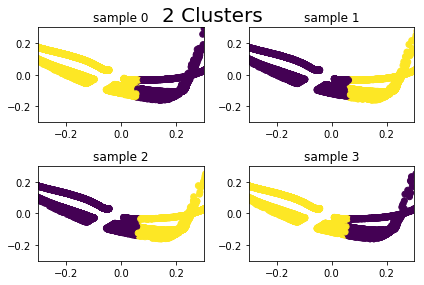

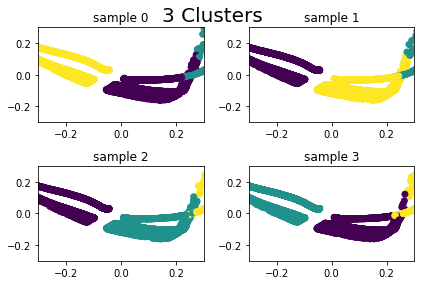

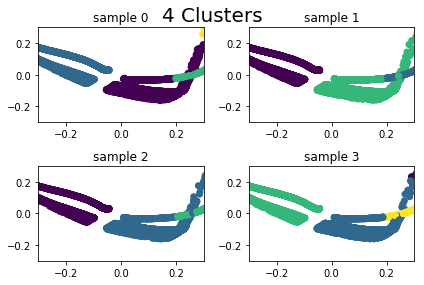

In [49]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [50]:
print(pd.DataFrame(pca.components_,columns=X.columns,index = ['PC-1','PC-2']))

        gender       10k  division       25k       age  official  genderdiv  \
PC-1  0.001023  0.028704  0.381520  0.072458  0.028102  0.126196   0.674031   
PC-2  0.001746  0.070049  0.391473  0.178609  0.066213  0.309579  -0.645409   

          35k   overall      pace       30k        5k       20k       40k  \
PC-1  0.10339 -0.580929  0.004820  0.087675  0.014311  0.057868  0.119071   
PC-2  0.25534 -0.226556  0.011825  0.216530  0.034683  0.142406  0.292527   

          half  
PC-1  0.061030  
PC-2  0.150188  


In [51]:
post_pca_array = pca.fit_transform(X_norm)

print(X_norm.shape)
(150, 4)

print(post_pca_array.shape)
(150, 2)

(31648, 15)
(31648, 2)


(150, 2)

Number of estimated clusters: 5


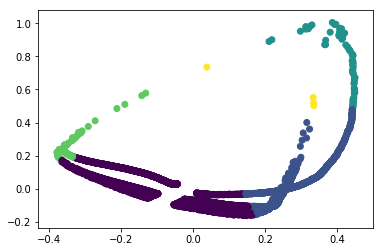

In [59]:
bandwidth = estimate_bandwidth(X_pca1, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca1)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_pca1[:, 0], X_pca1[:, 1], c=labels)
plt.show()

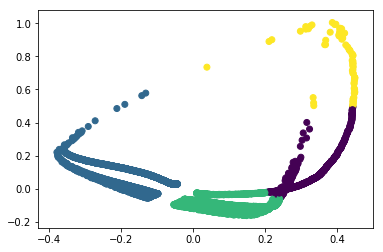

In [61]:
# We know we're looking for three clusters.
n_clusters=4

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_pca1)

#Predicted clusters.
predict=sc.fit_predict(X_pca1)

#Graph results.
plt.scatter(X_pca1[:, 0], X_pca1[:, 1], c=predict)
plt.show()


Done
Estimated number of clusters: 4591


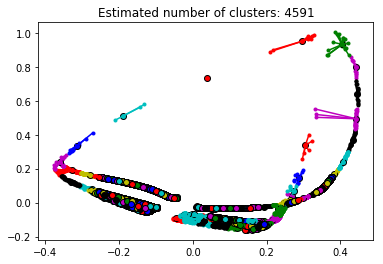

In [64]:
af = AffinityPropagation().fit(X_pca1)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_pca1[cluster_centers_indices[k]]
    plt.plot(X_pca1[class_members, 0], X_pca1[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_pca1[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()